## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

/home/hp/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw
Processing...


/home/hp/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_train)

60000

In [6]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break


torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

Переделаем архитектуру модели из предыдущей части лабы!

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 50),
            nn.BatchNorm1d(50),
            nn.LeakyReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(50, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
       BatchNorm1d-3                   [-1, 50]             100
         LeakyReLU-4                   [-1, 50]               0
           Dropout-5                   [-1, 50]               0
            Linear-6                   [-1, 50]           2,550
         LeakyReLU-7                   [-1, 50]               0
           Dropout-8                   [-1, 50]               0
            Linear-9                   [-1, 10]             510
       LogSoftmax-10                   [-1, 10]               0
Total params: 42,410
Trainable params: 42,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.16
Estimated Tot

/home/hp/.local/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Your experiments come here:

In [9]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
  train_loss = []
  val_loss = []
  val_accuracy = []

  for epoch in range(n_epochs):
    ep_train_loss = []
    ep_val_loss = []
    ep_val_accuracy = []

    model.train(True)
    for X_batch, y_batch in train_loader:

      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)

      predictions = model(X_batch)
      loss = loss_fn(predictions, y_batch)
      loss.backward()
      opt.step()
      opt.zero_grad()
      ep_train_loss.append(loss.item())

    model.train(False)
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
          X_batch = X_batch.to(device)
          y_batch = y_batch.to(device)

          predictions = model(X_batch)
          loss = loss_fn(predictions, y_batch)
          ep_val_loss.append(loss.item())
          y_pred = predictions.max(1)[1].data
          ep_val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
    
    
    train_loss.append(np.mean(ep_train_loss))
    val_loss.append(np.mean(ep_val_loss))
    val_accuracy.append(np.mean(ep_val_accuracy))

  return train_loss, val_loss, ep_val_accuracy

In [10]:
model = TinyNeuralNetwork().to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

In [11]:
train_loss, val_loss, val_accuracy = train_model(model, 
                                                 train_loader, 
                                                 test_loader, 
                                                 loss_fn, 
                                                 optimizer, 
                                                 n_epochs)


In [13]:
def plot_process(train_loss, val_loss, val_accuracy):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  axes[0].set_title("Loss")
  axes[0].plot(train_loss, label='train')
  axes[0].plot(val_loss, label='val')
  axes[0].legend()

  axes[1].set_title("Test accuracy")
  axes[1].plot(val_accuracy)

  fig.show()



0.9375


<ipython-input-13-019a62898fca>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


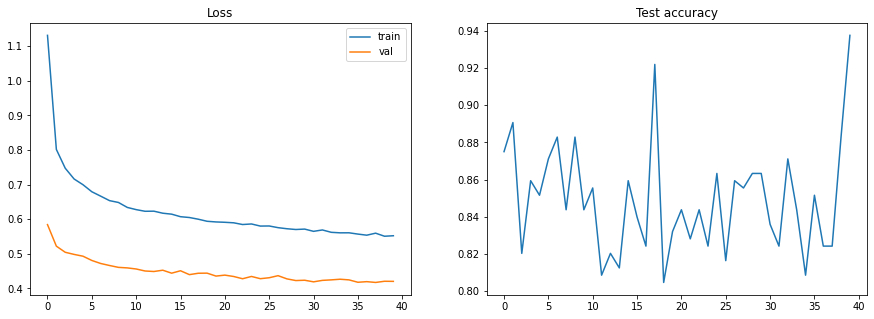

In [14]:
plot_process(train_loss, val_loss, val_accuracy)
print(max(val_accuracy))

Максимальное значение accuracy достигается по прошествии всех эпох, значит принимаем его за accuracy модели.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Уберем `Dropout` и `BatchNorm` из предыдущей модели и увеличим промежуточные признаковые пространства! 

In [33]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_shape, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 50),
            nn.LeakyReLU(),
            nn.Linear(50, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [17]:
model_overfit = OverfittingNeuralNetwork().to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

In [18]:
train_loss, val_loss, val_accuracy = train_model(model_overfit, 
                                                 train_loader, 
                                                 test_loader, 
                                                 loss_fn, 
                                                 optimizer, 
                                                 n_epochs)

<ipython-input-13-019a62898fca>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.1875
2.307230151284224


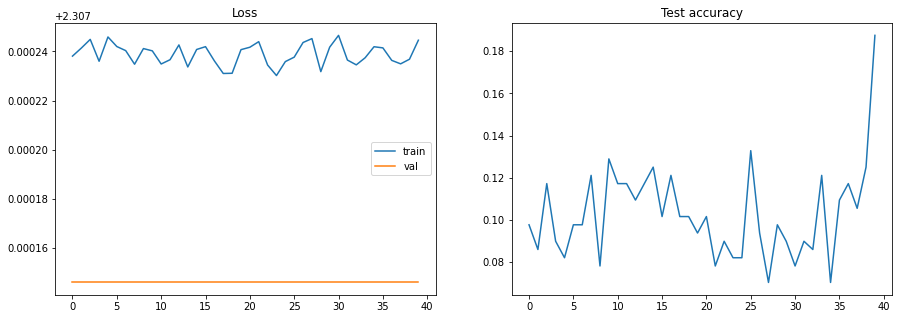

In [19]:
plot_process(train_loss, val_loss, val_accuracy)
print(max(val_accuracy))
print(min(train_loss))

👁👄👁 Таки шо получается


Изначально `loss` на валидации не думает улучшаться, а `loss` на тренировке на порядок меньше. Да и качество модели, что изначально, что после всех эпох удручает. Такие вот пирожки ...

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

Возаращаемся к изначальной модели.

### Conclusions:
_Write down small report with your conclusions and your ideas._

Мы выяснили, что модель с линейными слоями не справляется с поставленной задачей. Добавление BatchNorm нормирует промежуточные признаковые пространства, а Dropout делает модель более устойчивой, что в совокупности приводит к хорошему результату.